# Time Series Prediction with Duffing Equation Inspired Deep Learning ($DPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-11 21:31:50

## Gathering Dependencies

_Importing Required Libraries_

In [1]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

## Loading Datasets

_दिल्ली WIND SPEED_

In [3]:
data = pd.read_csv("datasets/delhi.csv")
training_set = data.iloc[:, 3]
print(training_set)

0       0.000000
1       2.980000
2       4.633333
3       1.233333
4       3.700000
          ...   
1457    3.547826
1458    6.000000
1459    6.266667
1460    7.325000
1461    0.000000
Name: wind_speed, Length: 1462, dtype: float64


## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [4]:
t_diff = 1 # Daily Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

42.22
1       2.980000
2       1.653333
3      -3.400000
4       2.466667
5      -2.220000
          ...   
1457   -4.787174
1458    2.452174
1459    0.266667
1460    1.058333
1461   -7.325000
Name: wind_speed, Length: 1461, dtype: float64
2      -1.326667
3      -5.053333
4       5.866667
5      -4.686667
6       7.040000
          ...   
1457   -4.337963
1458    7.239348
1459   -2.185507
1460    0.791667
1461   -8.383333
Name: wind_speed, Length: 1460, dtype: float64


In [5]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0       2.980000
1       1.653333
2      -3.400000
3       2.466667
4      -2.220000
          ...   
1456   -4.787174
1457    2.452174
1458    0.266667
1459    1.058333
1460   -7.325000
Name: wind_speed, Length: 1461, dtype: float64
0      -1.326667
1      -5.053333
2       5.866667
3      -4.686667
4       7.040000
          ...   
1455   -4.337963
1456    7.239348
1457   -2.185507
1458    0.791667
1459   -8.383333
Name: wind_speed, Length: 1460, dtype: float64


In [6]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(1461,)
()


## Plot of the External Forcing from Chaotic Differential Equation (_Duffing Equation_)

_Parameters_: $\alpha=0.5, \beta=1, \gamma=3, \delta=1\\$

<AxesSubplot:>

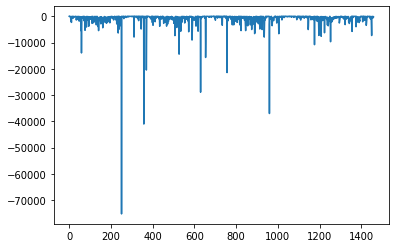

In [7]:
a=0.5
b=1
c=3
d=1
L = df.iloc[:, 2] -c + d*df.iloc[:, 1] - a*df.iloc[:, 0] - b*df.iloc[:, 0]**3
L.plot()

## Preprocessing the Data into Supervised Learning

In [8]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10    0.000000   2.980000   4.633333   1.233333   3.700000   1.480000   
11    2.980000   4.633333   1.233333   3.700000   1.480000   6.300000   
12    4.633333   1.233333   3.700000   1.480000   6.300000   7.142857   
13    1.233333   3.700000   1.480000   6.300000   7.142857  12.500000   
14    3.700000   1.480000   6.300000   7.142857  12.500000   7.400000   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)    var1(t)   var2(t)    var3(t)  
10   6.300000   7.142857  12.500000   7.400000  10.571429  2.657143 -11.252381  
11   7.142857  12.500000   7.400000  10.571429  13.228571 -8.595238   4.578571  
12  12.500000   7.400000  10.571429  13.228571   4.633333 -4.016667   3.928571  
13   7.400000  10.571429  13.228571   4.633333   0.616667 -0.088095  -0.440476  
14  10.571429  13.228571   4.633333   0.616667   0.528571 -0.528571   5.778571  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
  

## Train and Test Split

In [9]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1160, 1, 10) (1160, 3) (290, 1, 10) (290, 3)


## Defining the Physical Loss

In [10]:
a = tf.Variable(0.5, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(1, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(3, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(1, name="delta", trainable=True, dtype=tf.float32)


def phys(y_pred, y_true):
    return mean_absolute_error((y_true[:, 2] -c + d*y_true[:, 1] - a*y_true[:, 0] - b*y_true[:, 0]**3), (y_pred[:, 2] -c + d*y_pred[:, 1] - a*y_pred[:, 0] - b*y_pred[:, 0]**3))

def phys2(y_pred, y_real):
    pred = y_pred[2:]-2*y_pred[1:-1]-y_pred[:-2] -c + d*(y_pred[1:-1]-y_pred[:-2]) - a*y_pred[:-2] - b*y_pred[:-2]**3
    real = y_real[2:]-2*y_real[1:-1]-y_real[:-2] -c + d*(y_real[1:-1]-y_real[:-2]) - a*y_real[:-2] - b*y_real[:-2]**3
    return(mean_absolute_error(pred, real))

## Model ($DPINN$)

In [11]:
a = tf.Variable(0.1, name="alpha", trainable=True, dtype=tf.float32)
b = tf.Variable(0.05, name="beta", trainable=True, dtype=tf.float32)
c = tf.Variable(1.1, name="gamma", trainable=True, dtype=tf.float32)
d = tf.Variable(0.1, name="delta", trainable=True, dtype=tf.float32)

def loss_fn(y_true, y_pred):
    squared_difference = tf.square(y_true[:, 0] - y_pred[:, 0])
    squared_difference2 = tf.square(y_true[:, 2]-y_pred[:, 2])
    squared_difference1 = tf.square(y_true[:, 1]-y_pred[:, 1])
    squared_difference3 = tf.square(y_pred[:, 2] -c + d*y_pred[:, 1] - a*y_pred[:, 0] - b*y_pred[:, 0]**3)
    return tf.reduce_mean(squared_difference, axis=-1) + 0.2*tf.reduce_mean(squared_difference3, axis=-1)

model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss=loss_fn, optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
19/19 - 21s - loss: 0.2463 - val_loss: 0.2103 - 21s/epoch - 1s/step
Epoch 2/500
19/19 - 0s - loss: 0.1898 - val_loss: 0.1493 - 245ms/epoch - 13ms/step
Epoch 3/500
19/19 - 0s - loss: 0.1345 - val_loss: 0.0914 - 283ms/epoch - 15ms/step
Epoch 4/500
19/19 - 0s - loss: 0.0832 - val_loss: 0.0450 - 254ms/epoch - 13ms/step
Epoch 5/500
19/19 - 0s - loss: 0.0452 - val_loss: 0.0209 - 292ms/epoch - 15ms/step
Epoch 6/500
19/19 - 0s - loss: 0.0277 - val_loss: 0.0169 - 298ms/epoch - 16ms/step
Epoch 7/500
19/19 - 0s - loss: 0.0242 - val_loss: 0.0177 - 255ms/epoch - 13ms/step
Epoch 8/500
19/19 - 0s - loss: 0.0236 - val_loss: 0.0171 - 240ms/epoch - 13ms/step
Epoch 9/500
19/19 - 0s - loss: 0.0229 - val_loss: 0.0163 - 290ms/epoch - 15ms/step
Epoch 10/500
19/19 - 0s - loss: 0.0221 - val_loss: 0.0157 - 255ms/epoch - 13ms/step
Epoch 11/500
19/19 - 0s - loss: 0.0214 - val_loss: 0.0152 - 267ms/epoch - 14ms/step
Epoch 12/500
19/19 - 0s - loss: 0.0207 - val_loss: 0.0148 - 259ms/epoch - 14ms/step
Epoc

## Metrics ($DPINN$)

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
phy = phys2(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

10/10 [==============================] - 2s 4ms/step
(290, 3)
(290, 10)
Test RMSE: 3.552
Test MAE: 2.663


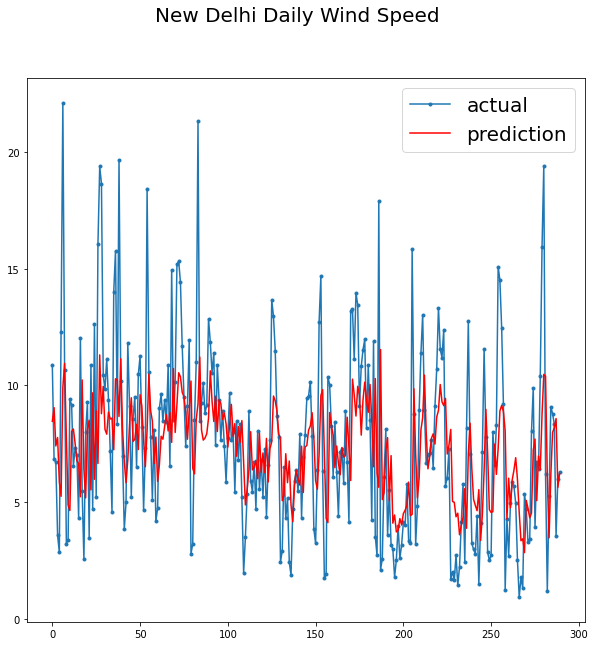

In [13]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('New Delhi Daily Wind Speed', fontsize=20)
plt.legend(fontsize=20)
plt.show()